<a href="https://colab.research.google.com/github/mebirtukan/Notebook-for-2DCNN_LSTM-for-Eye-Movement-Event-Detections/blob/main/1DCNN_BLSTM(State_of_art_approach).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python
# coding: utf-8
from datetime import datetime

import glob
import pickle
import json
#@title Import libraries

#%%writefile imoprt_libraries.py

from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import  TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPool1D, Conv2D
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, LSTM
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import f1_score
import os
import glob
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, TimeDistributed, Flatten, Activation, Dropout, Bidirectional
from keras.callbacks import History, TensorBoard, Callback
import keras.initializers as KI
from keras.layers import BatchNormalization

from keras import backend as K
import numpy as np
import os
from argparse import ArgumentParser
import math
from copy import deepcopy
import itertools
import warnings

# from sp_tool import util as sp_util
# from sp_tool.arff_helper import ArffHelper
# from sp_tool.evaluate import CORRESPONDENCE_TO_HAND_LABELLING_VALUES
# from sp_tool import recording_processor as sp_processor


In [ ]:
!wget www.kasprowski.pl/datasets/events.zip
!unzip events.zip > xx

--2023-11-20 19:01:07--  http://www.kasprowski.pl/datasets/events.zip
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2909538 (2.8M) [application/zip]
Saving to: ‘events.zip’

events.zip          100%[===================>]   2.77M  1.90MB/s    in 1.5s    

2023-11-20 19:01:09 (1.90 MB/s) - ‘events.zip’ saved [2909538/2909538]



In [ ]:
#@title Openfile function

#%%writefile openfile.py

def openfile(filename):
  mat = loadmat(filename)
  mdata = mat['ETdata']
  mtype = mdata.dtype
  ndata = {n: mdata[n][0,0] for n in mtype.names}
  ndata
  data_headline = ndata['pos']
  print(data_headline)
  data_headline = data_headline[0]
  data_raw = ndata['pos']
  len(data_raw)
  pdata = pd.DataFrame(data_raw,columns=data_headline)
#df=pd.DataFrame(pdata)
  print(pdata)
  df=pd.DataFrame(pdata)
  df=pd.DataFrame(pdata)
  df.dtypes
  df[1.0]=df[1.0].astype(int)
  df[1.0].dtypes
  t=pdata.iloc[:, 0].values
  x=pdata.iloc[:, 3:5].values
  y=pdata.iloc[:, 5].values
  x[0]
  x.shape[0]
  return t, x ,y


In [ ]:
#@title #Dataset Used for Evaluation
"The files we used are listed here"

files_to_load = ['data/UH47_video_BergoDalbana_labelled_RA.mat','data/UH29_video_dolphin_fov_labelled_RA.mat','data/UH47_video_BergoDalbana_labelled_MN.mat','data/UH29_video_dolphin_fov_labelled_MN.mat','data/TL30_video_triple_jump_labelled_RA.mat','data/TL30_video_triple_jump_labelled_MN.mat']#],'data/TH38_video_dolphin_fov_labelled_RA']
tt=[]
xx=[]
yy=[]
for file in files_to_load:
  T,X,Y=openfile(file)
  tt.append(T)
  xx.append(X)
  yy.append(Y)

[[2.30254838e+09 1.90000000e+01 1.80000000e+01 5.12111700e+02
  3.83055200e+02 1.00000000e+00]
 [2.30255338e+09 1.90000000e+01 1.90000000e+01 5.12586200e+02
  3.82839100e+02 1.00000000e+00]
 [2.30255838e+09 1.90000000e+01 1.90000000e+01 5.12721500e+02
  3.83162000e+02 1.00000000e+00]
 ...
 [2.31058334e+09 2.20000000e+01 2.20000000e+01 5.16795900e+02
  3.20544300e+02 1.00000000e+00]
 [2.31058834e+09 2.40000000e+01 2.20000000e+01 5.18114200e+02
  3.20650000e+02 1.00000000e+00]
 [2.31059334e+09 2.30000000e+01 2.30000000e+01 5.19719300e+02
  3.19982600e+02 1.00000000e+00]]
      2.302548e+09  1.900000e+01  1.800000e+01  5.121117e+02  3.830552e+02  \
0     2.302548e+09          19.0          18.0      512.1117      383.0552   
1     2.302553e+09          19.0          19.0      512.5862      382.8391   
2     2.302558e+09          19.0          19.0      512.7215      383.1620   
3     2.302563e+09          19.0          19.0      512.6691      384.2532   
4     2.302568e+09          18.0  

1609
 max_velocity= 0.22385680122926604
min_vel= -0.008030265863458598
min acc= -4.418063707530866e-05
max acc= 4.328496380704161e-05
min jerk= -1.6078913211868497e-08
max jerk= 1.6590805798511353e-08
max distance= 1119.0946677607176
min distanve= -40.15132931729299


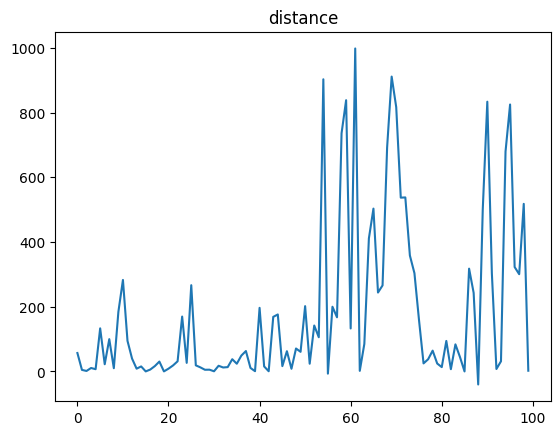

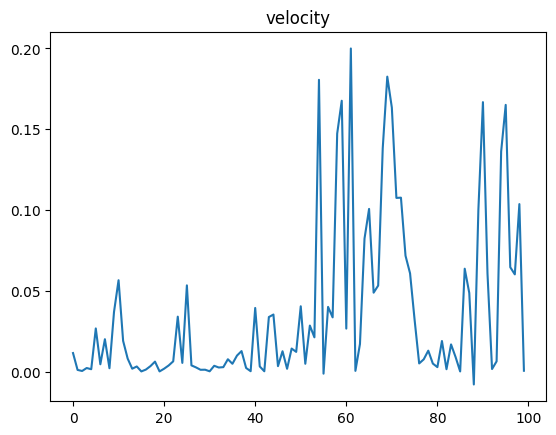

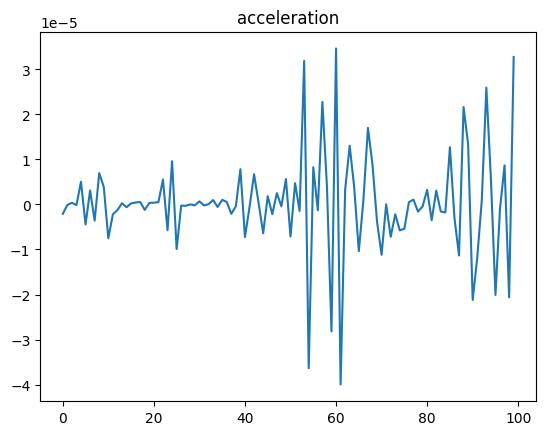

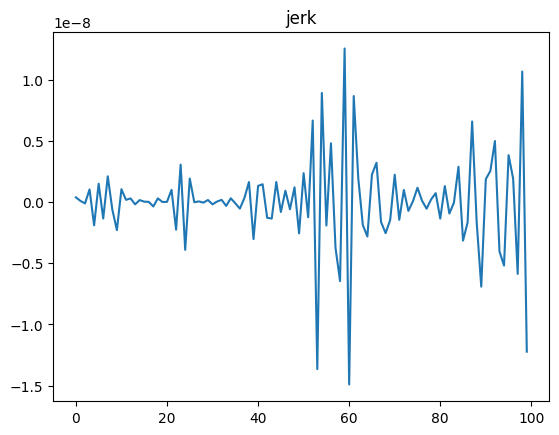

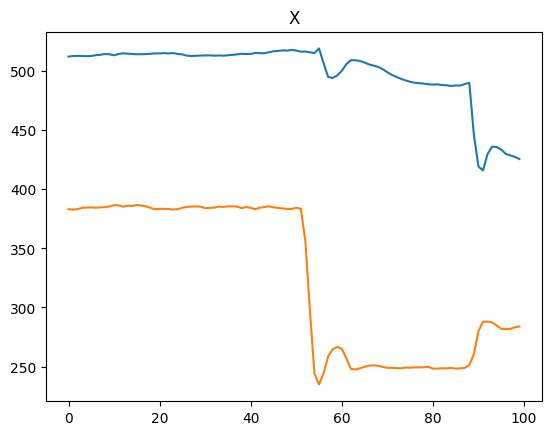

4045
 max_velocity= 0.7721700619568297
min_vel= -0.011087256739390655
min acc= -0.0003724909073149951
max acc= 0.00036034927565651914
min jerk= -3.640133512873786e-07
max jerk= 3.324993190962382e-07
max distance= 1544.3401239136595
min distanve= -22.1856007355207


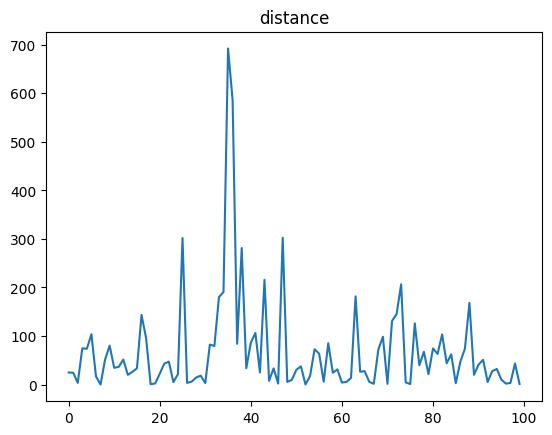

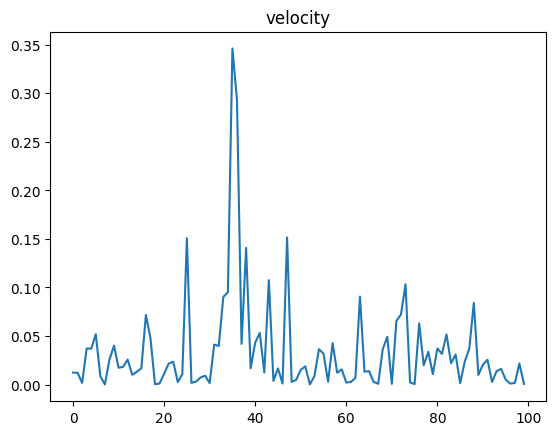

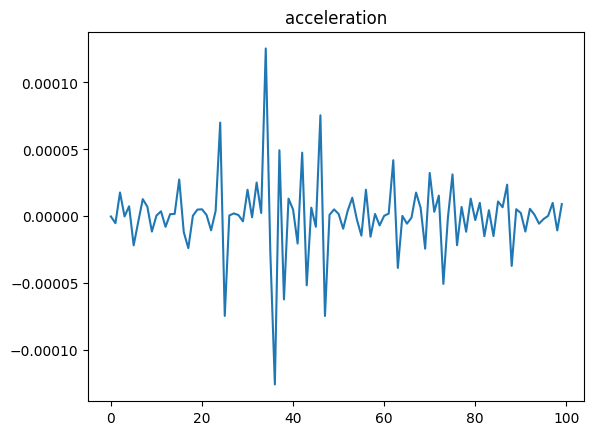

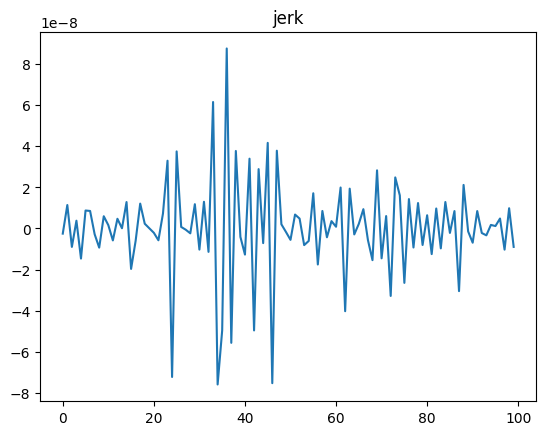

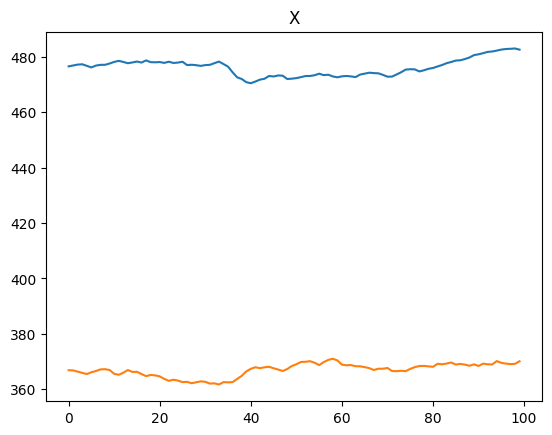

1609
 max_velocity= 0.22385680122926604
min_vel= -0.008030265863458598
min acc= -4.418063707530866e-05
max acc= 4.328496380704161e-05
min jerk= -1.6078913211868497e-08
max jerk= 1.6590805798511353e-08
max distance= 1119.0946677607176
min distanve= -40.15132931729299


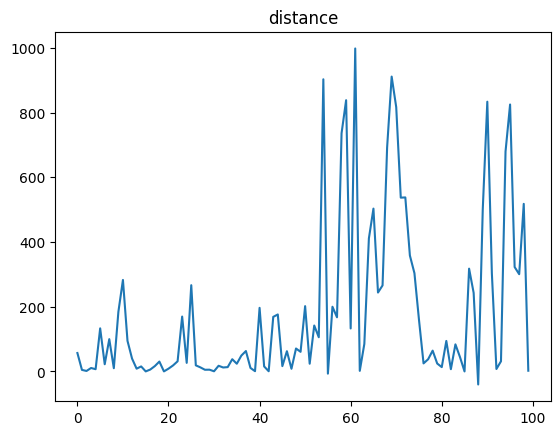

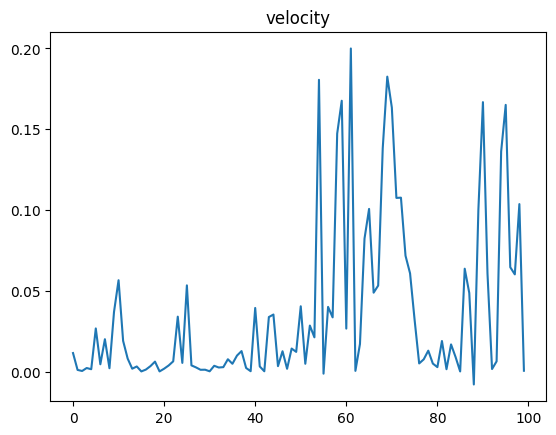

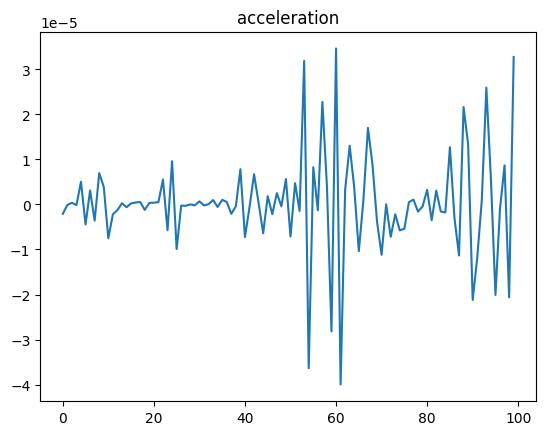

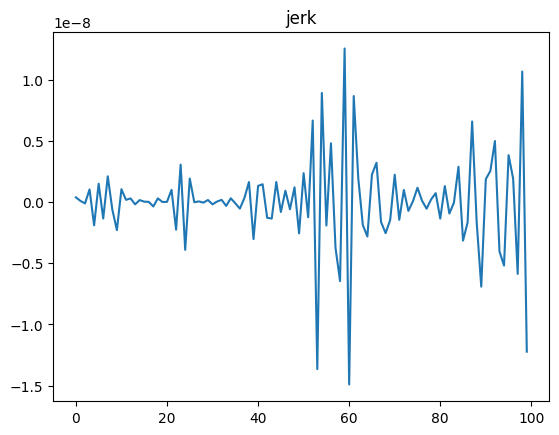

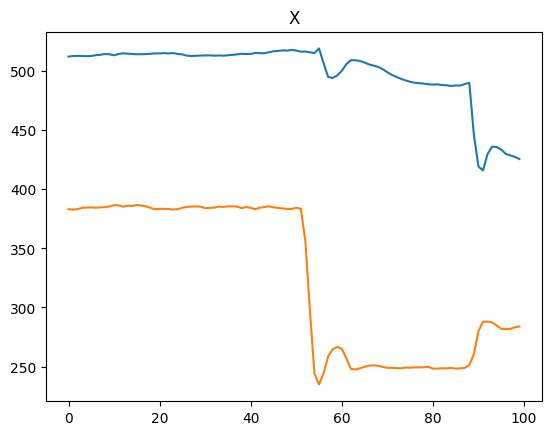

4045
 max_velocity= 0.7721700619568297
min_vel= -0.011087256739390655
min acc= -0.0003724909073149951
max acc= 0.00036034927565651914
min jerk= -3.640133512873786e-07
max jerk= 3.324993190962382e-07
max distance= 1544.3401239136595
min distanve= -22.1856007355207


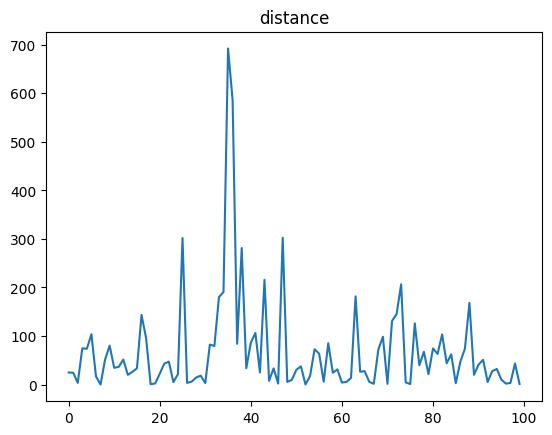

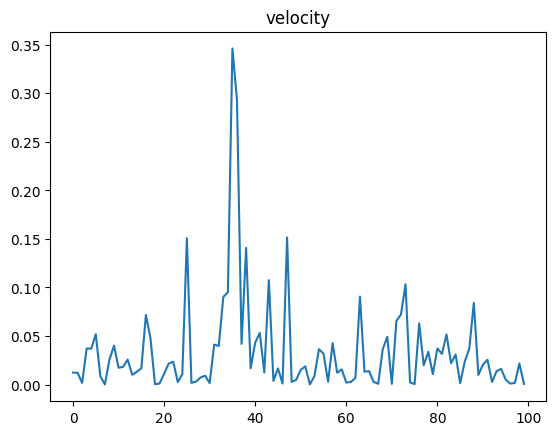

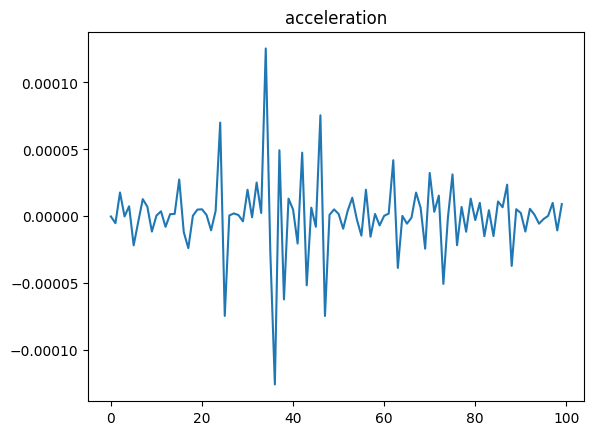

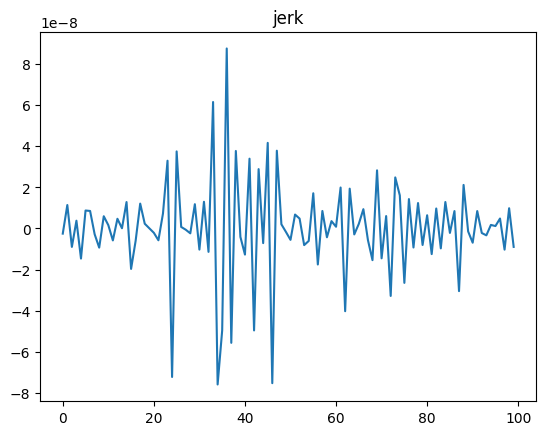

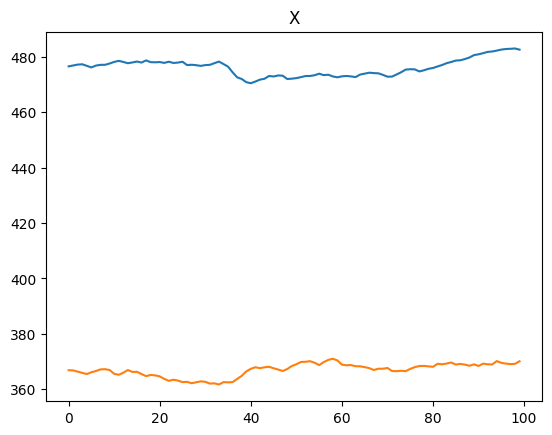

4022
 max_velocity= 0.5826234420924514
min_vel= 1.268976434454057e-07
min acc= -0.0002498792824977778
max acc= 0.000253900032740497
min jerk= -2.0638254009562669e-07
max jerk= 2.386015641985699e-07
max distance= 1165.246884184903
min distanve= 0.0002535414916039206


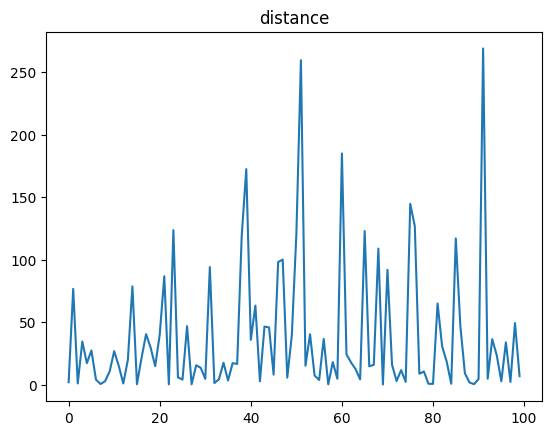

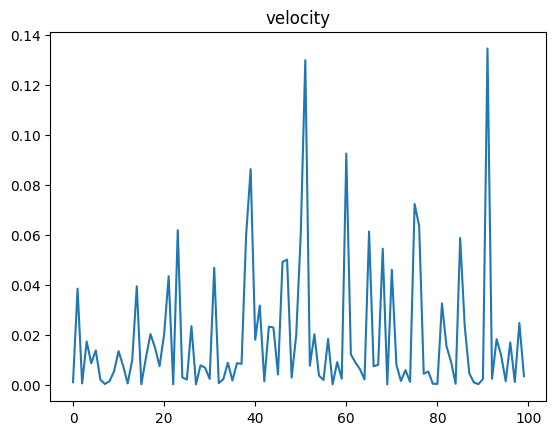

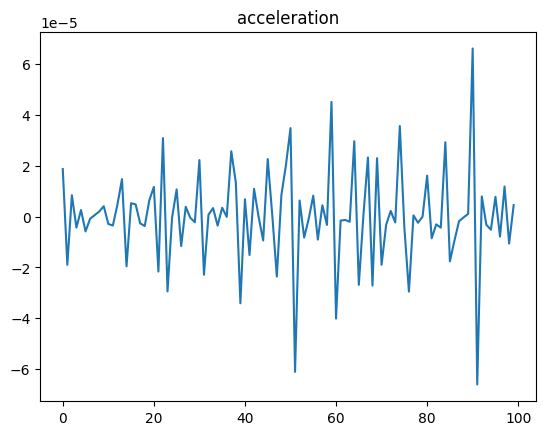

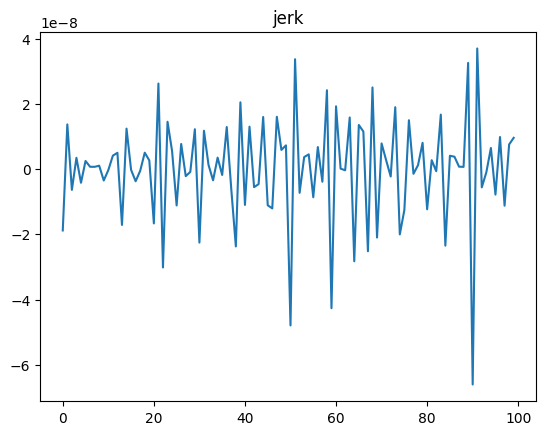

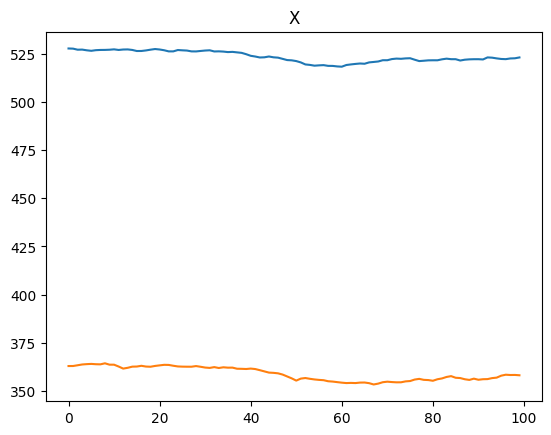

2819
 max_velocity= 0.8663484829098707
min_vel= -0.0149676241177114
min acc= -0.00042629815766494314
max acc= 0.0004279436683664416
min jerk= -4.1030256784948575e-07
max jerk= 3.7631185581318706e-07
max distance= 1732.6969658197413
min distanve= -29.9352482354228


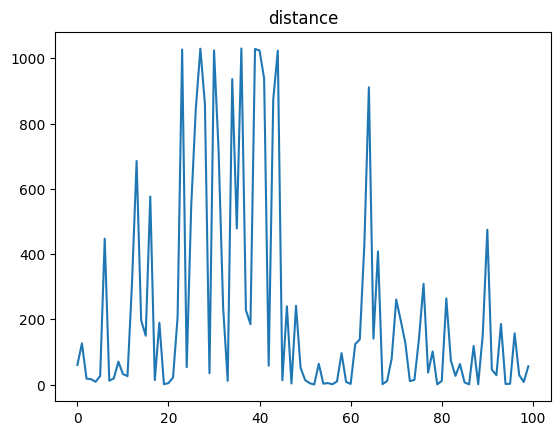

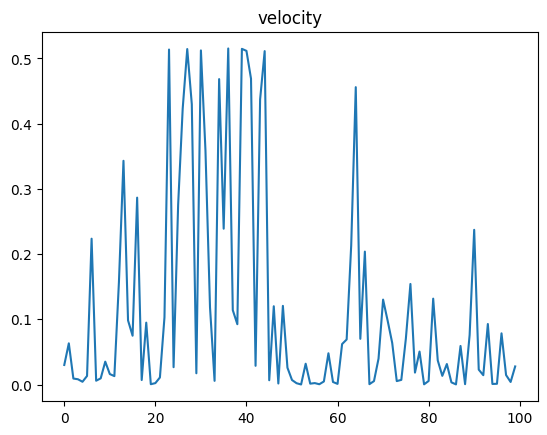

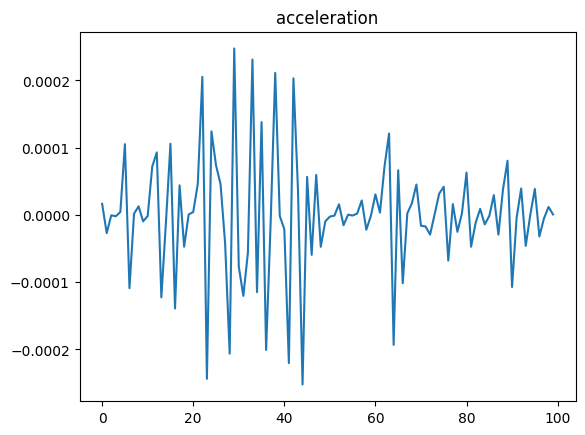

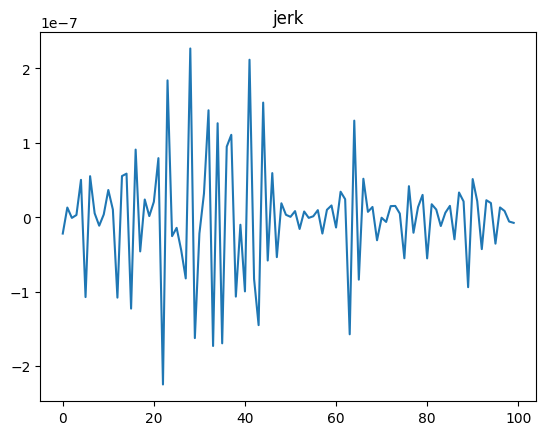

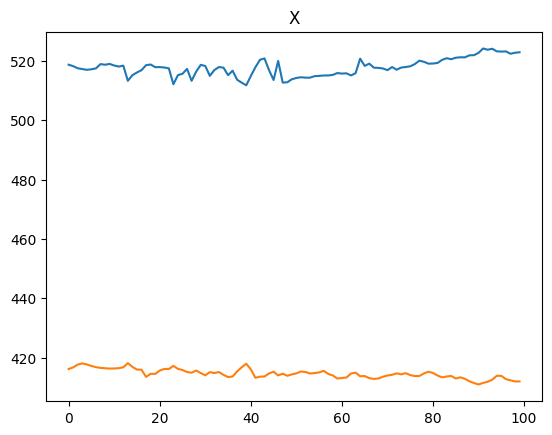

4022
 max_velocity= 0.5826234420924514
min_vel= 1.268976434454057e-07
min acc= -0.0002498792824977778
max acc= 0.000253900032740497
min jerk= -2.0638254009562669e-07
max jerk= 2.386015641985699e-07
max distance= 1165.246884184903
min distanve= 0.0002535414916039206


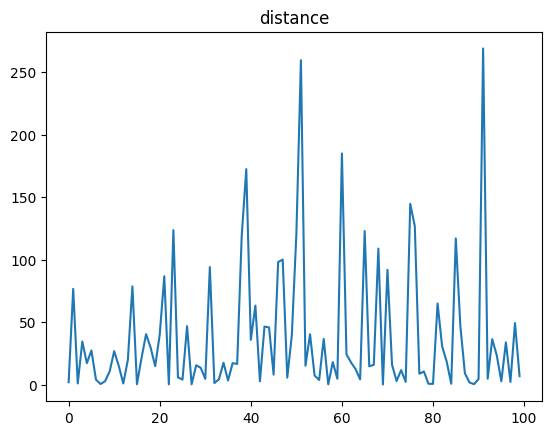

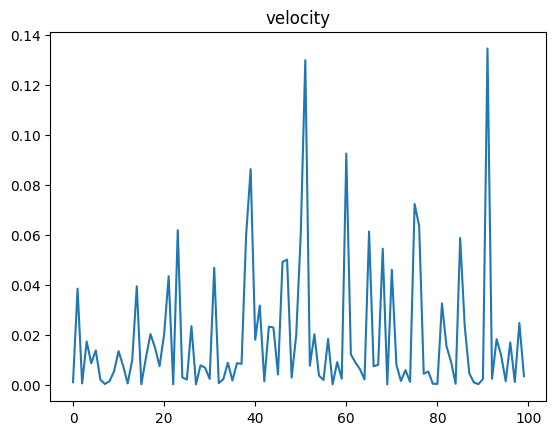

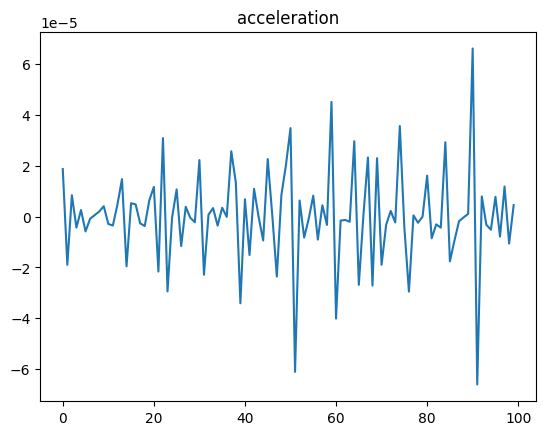

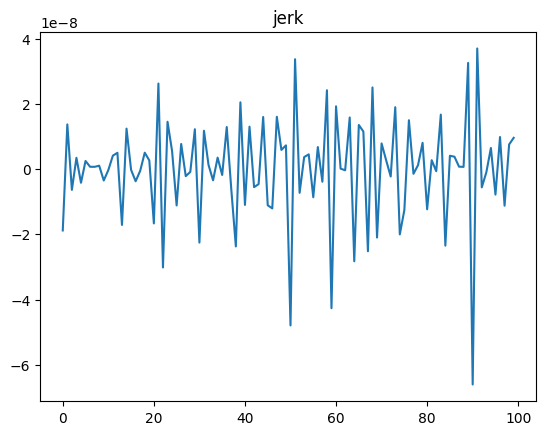

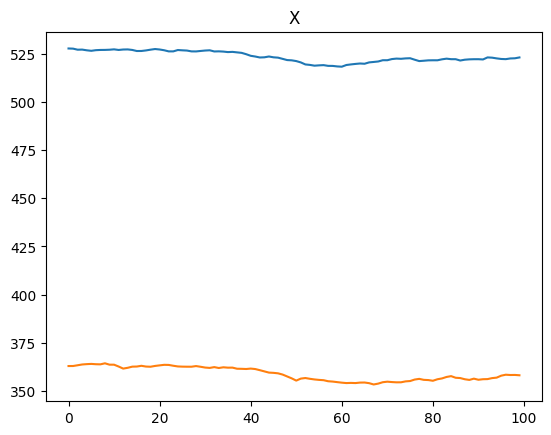

2819
 max_velocity= 0.8663484829098707
min_vel= -0.0149676241177114
min acc= -0.00042629815766494314
max acc= 0.0004279436683664416
min jerk= -4.1030256784948575e-07
max jerk= 3.7631185581318706e-07
max distance= 1732.6969658197413
min distanve= -29.9352482354228


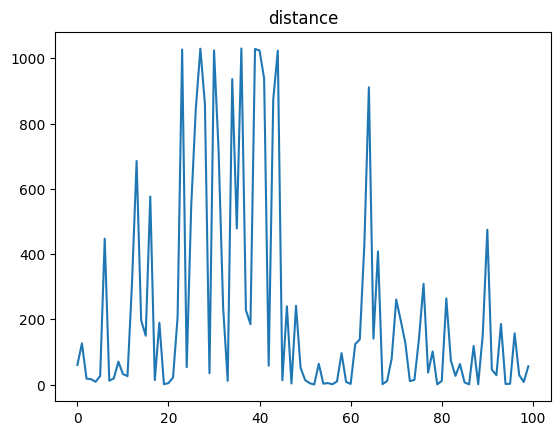

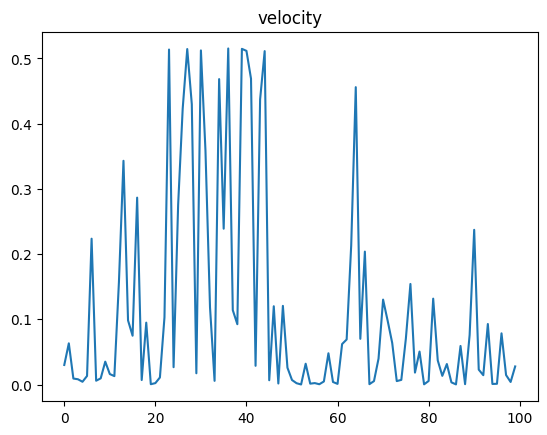

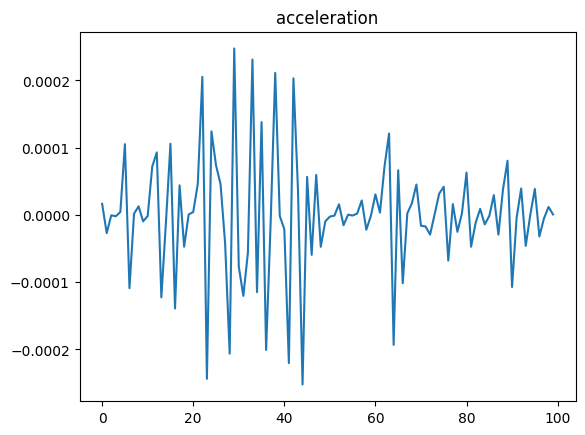

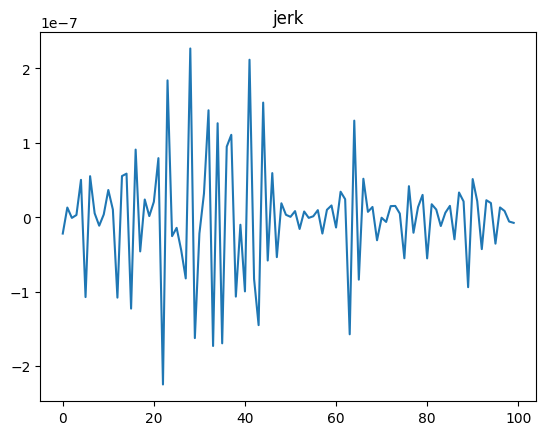

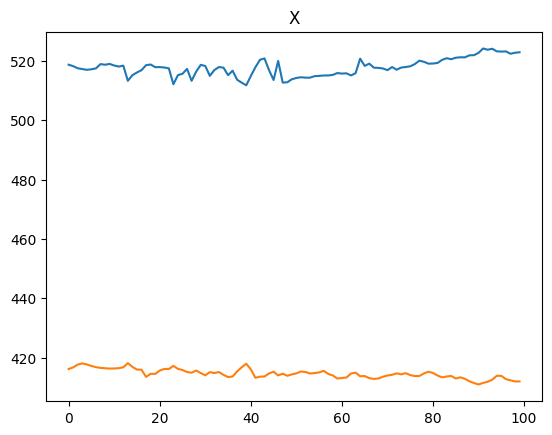

4043
 max_velocity= 0.7772236893347643
min_vel= -0.008311959158042797
min acc= -0.0003614262669465809
max acc= 0.0003628335236915072
min jerk= -3.3748980685464626e-07
max jerk= 3.1409827736814824e-07
max distance= 1551.17727195081
min distanve= -16.632230275243636


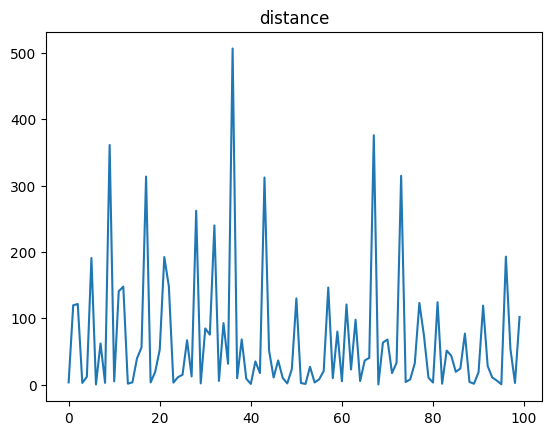

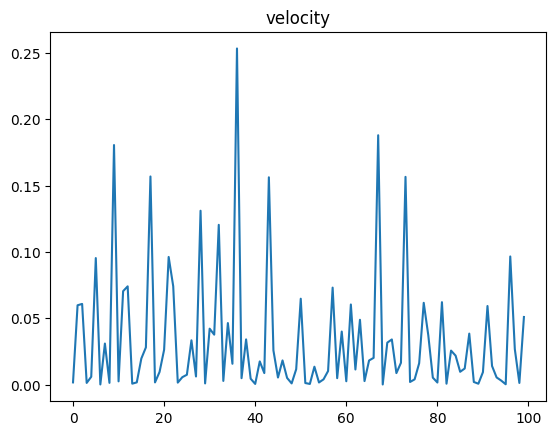

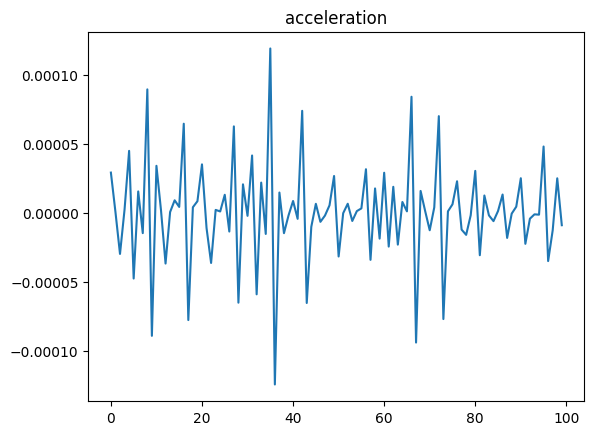

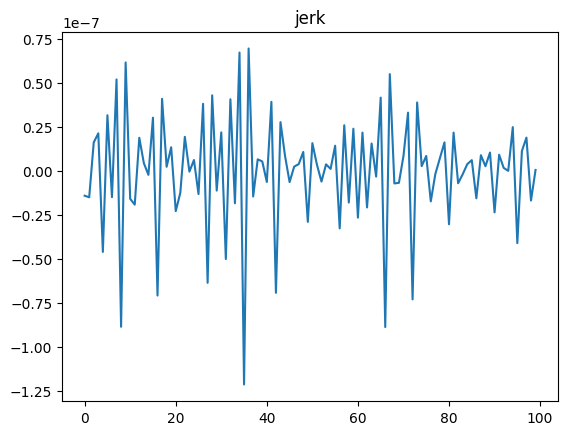

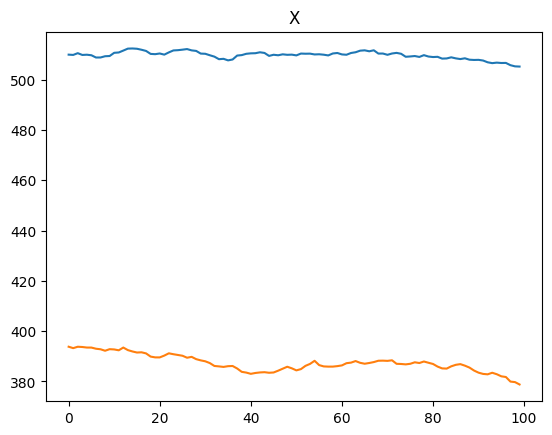

In [ ]:
#@title #Calculate  and combine features

from numpy.core.fromnumeric import mean
import csv
import numpy as np
import math
def calculate_features(data, Time):
  times = Time#data[:,[0]]
  ts = []

  # convert time to second
  for T in times:
    ts.append(float(T)/1000.0)

  Xs = data[:,[0]]
  Ys = data[:,[1]]
  global Direction
  Direction=[]
  global distance
  distance=[]

  diffX = [] #x values difference
  diffY = [] #y values difference
  diffT = [] #time values difference

  for i in range(len(data) - 1):
   diffX.append((float(Xs[i+1])) - float(Xs[i])*math.cos(float(Xs[i+1])-float(Xs[i] )))
   diffY.append((float(Ys[i+1]) - float(Ys[i]))*math.sin(float(Ys[i+1])-float(Ys[i] )))

  for i in range(len(diffX)):
    distance.append((diffX[i]+diffY[i]))

    diffT.append(float(ts[i+1])*1000 - float(ts[i])*1000 )
  for j in range(len(diffX)):
    Direction.append(math.atan2(diffX[j], diffY[j]))

  global velocity
  global acceleration
  global jerk
  Jounce=[]
  Velocity=[]
  Jerk=[]
  Acceleration=[]


  for i in range(len(distance)-1):

    Velocity.append(np.divide(((distance[i+1])-(distance[i])),(diffT[i])))

  for i in range(len(Velocity)-1):
    Acceleration.append(np.divide(((Velocity[i+1])-(Velocity[i])),((diffT[i]))))

  for i in range(len(Acceleration)-1):
    Jerk.append(np.divide(((Acceleration[i+1])-(Acceleration[i])),((diffT[i]))))


  Velocity = Velocity[:len(Jerk)]
  Acceleration = Acceleration[:len(Jerk)]
  Direction = Direction[:len(Jerk)]



  print(' max_velocity=',max(Velocity))
  print('min_vel=', min(Velocity))
  print('min acc=', min(Acceleration))
  print('max acc=', max(Acceleration))
  print('min jerk=', min(Jerk))
  print('max jerk=', max(Jerk))
  print('max distance=', max(distance))
  print('min distanve=', min(distance))


## visualisation
  size = 100
  plt.plot(distance[:size])
  plt.title("distance")
  plt.show()
  plt.plot(Velocity[:size])
  plt.title("velocity")
  plt.show()
  plt.plot(Acceleration[:size])
  plt.title("acceleration")
  plt.show()
  plt.plot(Jerk[:size])
  plt.title("jerk")
  plt.show()
  plt.plot(data[:size])
  plt.title("X")
  plt.show()



  return Velocity, Acceleration, Jerk, Direction

vel0, acc0, jerk0, dir0=calculate_acc(x0, t0)
vel1, acc1, jerk1, dir1=calculate_acc(x1, t1)
vel2, acc2, jerk2, dir2=calculate_acc(x2, t2)
vel3, acc3, jerk3, dir3=calculate_acc(x3, t3)
vel4, acc4, jerk4, dir4=calculate_acc(x4, t4)
vel5, acc5, jerk5, dir5=calculate_acc(x5, t5)
vel6, acc6, jerk6, dir6=calculate_acc(x6, t6)
vel7, acc7, jerk7, dir7=calculate_acc(x7, t7)
vel8, acc8, jerk8, dir8=calculate_acc(x8, t8)



In [ ]:
#@title #Convert samples into chunks of sequence_dim length with lag = sequence_lag

#LIST OF FILES USED
VD0=np.vstack((vel0, dir0)).T
VD1=np.vstack((vel1, dir1)).T
VD2=np.vstack((vel2, dir2)).T
VD3=np.vstack((vel3, dir3)).T
VD4=np.vstack((vel4, dir4)).T
VD5=np.vstack((vel5, dir5)).T


def make_sequences1(samples, labels, sequence_dim = 100, sequence_lag = 1, sequence_attributes = 2):
    nsamples = []
    nlabels = []
    for i in range(0,samples.shape[0]-sequence_dim,sequence_lag):
            nsample = np.zeros((sequence_dim,sequence_attributes))
            for j in range(i,i+sequence_dim):
                nsample[j-i,0] = samples[j,0]
                nsample[j-i,1] = samples[j,1]

            nlabel = labels[i+sequence_dim//2]
            nsamples.append(nsample)
            nlabels.append(nlabel)

    samples = np.array(nsamples)
    labels = np.array(nlabels)
    return samples,labels


sequence_dim = 50
print("Converting to sequences of length {}".format(sequence_dim))
XVD0,YVD0 = make_sequences1(VD0, y0, sequence_dim)
XVD1,YVD1 = make_sequences1(VD1, y1, sequence_dim)
XVD2,YVD2 = make_sequences1(VD2, y2, sequence_dim)
XVD3,YVD3 = make_sequences1(VD3, y3, sequence_dim)
XVD4,YVD4 = make_sequences1(VD4, y4, sequence_dim)
XVD5,YVD5 = make_sequences1(VD5, y5, sequence_dim)


X_a=XVD0,XVD1,XVD2,XVD3,XVD4,XVD5
y_a=YVD0,YVD1,YVD2,YVD3,YVD4,YVD5





Converting to sequences of length 50


In [ ]:
# @title #Model Building and evaluation
CM=[]
YAD_TOTAL=[]
K_AD=[]
ad_total=[]
def create_model(num_classes, batch_size, train_data_shape=(X_a_train.shape), dropout_rate=0.3,
                 padding_mode='valid',
                 num_conv_layers=3, conv_filter_counts=(32, 16, 8),
                 num_dense_layers=1, dense_units_count=(32,),
                 num_blstm_layers=1, blstm_unit_counts=(16,),
                 unroll_blstm=False,
                 stateful=False,
                 no_bidirectional=True):
    """
    Create a 1D CNN-BLSTM model that contains 3 blocks of layers: Conv1D block, Dense block, and BLSTM block.
    Each of these is configurable via the parameters of this function; only the convolutional block cannot be entirely
    skipped.

    Each layer in the Conv1D block has the filter size of 3, and is followed by BatchNormalization and ReLU activation.
    Every layer in this block, starting from the second one, is preceded by Dropout.

    In the Dense block, every layer uses a TimeDistributed wrapper and is preceded by Dropout, followed by ReLU
    activation.

    All [B]LSTM layer(s) use tanh activation.

    After the BLSTM block, the model contains a single (time-distributed) Dense layer with softmax activation that
    has the @num_classes units.


    :param num_classes: number of classes to be classified
    :param batch_size: batch size
    :param train_data_shape: shape of the training data array (will infer sequence length -- @train_data_shape[1] -- and
                             number of features -- train_data_shape[2] -- here, @train_data_shape[0] is ignored, and
                             @batch_size is used instead).
    :param dropout_rate: each convolutional (except for the first one) and dense layer is preceded by Dropout with this
                         rate.
    :param padding_mode: convolution padding mode; can be 'valid' (default), 'same', or 'causal'; the latter can be
                         useful, if a modification into a realtime-like model is desired:
                         https://keras.io/layers/convolutional/#conv1d
    :param num_conv_layers: number of convolutional layers in the Conv1D block
    :param conv_filter_counts: number of filters in each respective Conv1D layer; has to be of length of at least
                               @num_conv_layers - will use the first @num_conv_layers elements
    :param num_dense_layers: number of dense layers in the Dense block
    :param dense_units_count: number of units in each respective Dense layer; has to be of length of at least
                              @num_dense_layers - will use the first @num_dense_layers elements
    :param num_blstm_layers: number of dense layers in the BLSTM block
    :param blstm_unit_counts: number of units in each respective [B]LSTM layer; has to be of length of at least
                              @num_blstm_layers - will use the first @num_blstm_layers elements
    :param unroll_blstm: whether to unroll the [B]LSTM(s), see https://keras.io/layers/recurrent/#lstm
    :param stateful: whether to make the [B]LSTM(s) stateful; not used yet
    :param no_bidirectional: if True, will use traditional LSTMs, not the Bidirectional wrapper,
                             see https://keras.io/layers/wrappers/#bidirectional
    :return: a keras.models.Sequential() model
    """
    assert num_conv_layers <= len(conv_filter_counts)
    if len(conv_filter_counts) != num_conv_layers:
        warnings.warn('@num_conv_layers={} is shorter than @conv_filter_counts={}, so the last {} elements of the '
                      'latter will be ignored. Might be incorrectly passed arguments!'.format(
                        num_conv_layers, conv_filter_counts, len(conv_filter_counts) - num_conv_layers))

    assert num_dense_layers <= len(dense_units_count)
    if len(dense_units_count) != num_dense_layers:
        warnings.warn('@num_dense_layers={} is shorter than @dense_unit_counts={}, so the last {} elements of the '
                      'latter will be ignored. Might be incorrectly passed arguments!'.format(
                       num_dense_layers, dense_units_count, len(dense_units_count) - num_dense_layers))

    assert num_blstm_layers <= len(blstm_unit_counts)
    if len(blstm_unit_counts) != num_blstm_layers:
        warnings.warn('@num_blstm_layers={} is shorter than @blstm_unit_counts={}, so the last {} elements of the '
                      'latter will be ignored. Might be incorrectly passed arguments!'.format(
                        num_conv_layers, conv_filter_counts, len(blstm_unit_counts) - num_blstm_layers))

    model = Sequential()

    for conv_layer_id in range(num_conv_layers):
        if conv_layer_id != 0:
            model.add(Dropout(dropout_rate))

        conv_layer_args = {
            'filters': conv_filter_counts[conv_layer_id],
            'kernel_size': 3,
            'padding': padding_mode,
            'kernel_initializer': KI.RandomNormal(),
            'bias_initializer': KI.Ones()
        }
        # special args for the first layer
        if conv_layer_id == 0:
            conv_layer_args['batch_input_shape'] = (batch_size, train_data_shape[1], train_data_shape[2])

        model.add(Conv1D(**conv_layer_args))
        model.add(BatchNormalization(axis=-1))
        model.add(Activation('relu'))

    model.add(TimeDistributed(Flatten()))

    for dense_layer_id in range(num_dense_layers):
        model.add(Dropout(dropout_rate))
        model.add(TimeDistributed(Dense(dense_units_count[dense_layer_id], activation='relu',
                                        kernel_initializer=KI.RandomNormal(),
                                        bias_initializer=KI.Ones())))

    for blstm_layer_id in range(num_blstm_layers):
        if not no_bidirectional:
            model.add(Bidirectional(LSTM(blstm_unit_counts[blstm_layer_id],
                                         return_sequences=False, stateful=stateful,
                                         unroll=unroll_blstm)))
        else:
            model.add(LSTM(blstm_unit_counts[blstm_layer_id],
                           return_sequences=False, stateful=stateful,
                           unroll=unroll_blstm))

    model.add((Dense(num_classes, activation='softmax',
                                    kernel_initializer=KI.RandomNormal(),
                                    bias_initializer=KI.Ones())))

    model.summary()
    for i in range(6):
      X_a_train = np.concatenate([(X_a[j]) for j in range(len(X_a)) if j != i])
      y_a_train = np.concatenate([(y_a[j]) for j in range(len(y_a)) if j != i])
      X_a_test = (X_a[i])
      y_a_test = (y_a[i])
      lb = LabelBinarizer()
      lb.fit(y_a_train)
      lb.fit(y_a_test)
      y_a_train = lb.transform(y_a_train)
      y_a_test = lb.transform(y_a_test)
      model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[tf.keras.metrics.CategoricalAccuracy()])
      model.fit(X_a_train, y_a_train,batch_size=50, epochs=25
            ,validation_data=(X_a_test,y_a_test)

               )

      print("Test")
      A_RESULT = model.predict(X_a_test)
      print(confusion_matrix(y_a_test.argmax(axis=1), A_RESULT.argmax(axis=1)))
      #print(classification_report(y_ad_test.argmax(axis=1), A_D_RESULT.argmax(axis=1)))
      CM.append((confusion_matrix(y_a_test.argmax(axis=1), A_RESULT.argmax(axis=1))))
      print("CNN Accuracy: {:.2f}".format(accuracy_score(y_a_test.argmax(axis=1), A_RESULT.argmax(axis=1))))
      print("Cohen's Kappa {:.2f}".format(cohen_kappa_score(y_a_test.argmax(axis=1), A_RESULT.argmax(axis=1))))
      ad_total.append(A_RESULT.argmax(axis=1))# Reverse binarize
      YAD_TOTAL.append(y_a_test.argmax(axis=1))
      K_AD.append((cohen_kappa_score(y_a_test.argmax(axis=1), A_RESULT.argmax(axis=1))))
    print('mean K=',(K_AD[0]+K_AD[1]+K_AD[2]+K_AD[3]+K_AD[4]+K_AD[5])/len(X))
    CM_MEAN=(CM[0]+CM[1]+CM[2]+CM[3]+CM[4]+CM[5])/len(X)
    # PLOT MEAN CONFUSION MATRIX
    CM_MEAN=np.round(CM_MEAN/np.sum(CM_MEAN, axis=1).reshape(-1, 1), 2)
    from matplotlib.pyplot import figure
    figure(figsize=(3, 2),dpi=600)
    sns.heatmap(CM_MEAN, cmap='Blues', annot=True, cbar_kws={"orientation": "vertical", "label": "color bar"}, xticklabels=['fix','sac','pso','sp'], yticklabels=['fix', 'sac', 'pso','sp'])
    plt.xlabel("Predicted value")
    plt.ylabel("Actual value")
    plt.title("1D_CNN_BLSTM")
    plt.show()
    #CALCULATE METRICS (F1_SCORE, RECALL, PRECISSION)
    #FIXATION RECALL
    sumf=CM_MEAN[0][0]+CM_MEAN[0][1]+CM_MEAN[0][2]+CM_MEAN[0][3]
    Tc=CM_MEAN[0][0]
    print('Fixation recall=',(Tc*100/sumf))

    #fixation precision
    sumfp=CM_MEAN[0][0]+CM_MEAN[1][0]+CM_MEAN[2][0]+CM_MEAN[3][0]
    Tcfp=CM_MEAN[0][0]
    print('fixation_precision=',(Tcfp*100/sumfp))
    #fixation f1_score
    multiple_recal_prec=2*((Tcfp*100/sumfp)*(Tc*100/sumf))
    add_recall_prec=((Tc*100/sumf)+Tcfp*100/sumfp)
    result_f1_score=multiple_recal_prec/add_recall_prec
    print('fixation_f1_score=',(result_f1_score))
    #Saccade RECALL calculation
    sums=CM_MEAN[1][0]+CM_MEAN[1][1]+CM_MEAN[1][2]+CM_MEAN[1][3]
    Tcs=CM_MEAN[1][1]
    print('saccade_recall=',(Tcs*100/sums))

    #Saccade precison
    sum_saccP=CM_MEAN[0][1]+CM_MEAN[1][1]+CM_MEAN[2][1]+CM_MEAN[3][1]
    Tc_saccP=CM_MEAN[1][1]
    print('saccade_precision=',(Tc_saccP*100/sum_saccP))
    #saccade f1_score
    multiply=2*((Tc_saccP*100/sum_saccP)*(Tcs*100/sums))
    addition=(Tcs*100/sums)+(Tc_saccP*100/sum_saccP)
    print('saccade_f1_score=',(multiply/addition))
    #PSO RECALL
    sum_pso=CM_MEAN[2][0]+CM_MEAN[2][1]+CM_MEAN[2][2]+CM_MEAN[2][3]
    Tc_pso=CM_MEAN[2][2]
    print('PSO recall=',(Tc_pso*100/sum_pso))

    #PSO precision
    sum_psop=CM_MEAN[0][2]+CM_MEAN[1][2]+CM_MEAN[2][2]+CM_MEAN[3][2]
    #Tcfp=CM_MEAN[2][2]
    fixation_precision=(Tc_pso*100/sum_psop)
    print('PSO precission=',(Tc_pso*100/sum_psop))
    #PSO f1_score
    multiple_recal_prec_pso=2*((Tc_pso*100/sum_pso)*(Tc_pso*100/sum_psop))
    add_recall_prec_pso=((Tc_pso*100/sum_pso)+Tc_pso*100/sum_psop)
    result_f1_score_pso=multiple_recal_prec_pso/add_recall_prec_pso
    print('PSO_f1_score=',(result_f1_score_pso))
    #SP RECALL
    sum_sp=CM_MEAN[3][0]+CM_MEAN[3][1]+CM_MEAN[3][2]+CM_MEAN[3][3]
    Tc_sp=CM_MEAN[3][3]
    print('SP recall=',(Tc_sp*100/sum_sp))

    #SP precision
    sum_spp=CM_MEAN[0][3]+CM_MEAN[1][3]+CM_MEAN[2][3]+CM_MEAN[3][3]
    #Tcfp=CM_MEAN[2][2]
    sp_precision=(Tc_sp*100/sum_spp)
    print('SP precission=',(Tc_sp*100/sum_spp))
    #SP f1_score
    multiple_recal_prec_sp=2*((Tc_sp*100/sum_sp)*(Tc_sp*100/sum_spp))
    add_recall_prec_sp=((Tc_sp*100/sum_sp)+Tc_sp*100/sum_spp)
    result_f1_score_sp=multiple_recal_prec_sp/add_recall_prec_sp
    print('SP_f1_score=',(result_f1_score_sp))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (50, 48, 32)              224       
                                                                 
 batch_normalization_18 (Ba  (50, 48, 32)              128       
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (50, 48, 32)              0         
                                                                 
 dropout_18 (Dropout)        (50, 48, 32)              0         
                                                                 
 conv1d_19 (Conv1D)          (50, 46, 16)              1552      
                                                                 
 batch_normalization_19 (Ba  (50, 46, 16)              64        
 tchNormalization)                                    

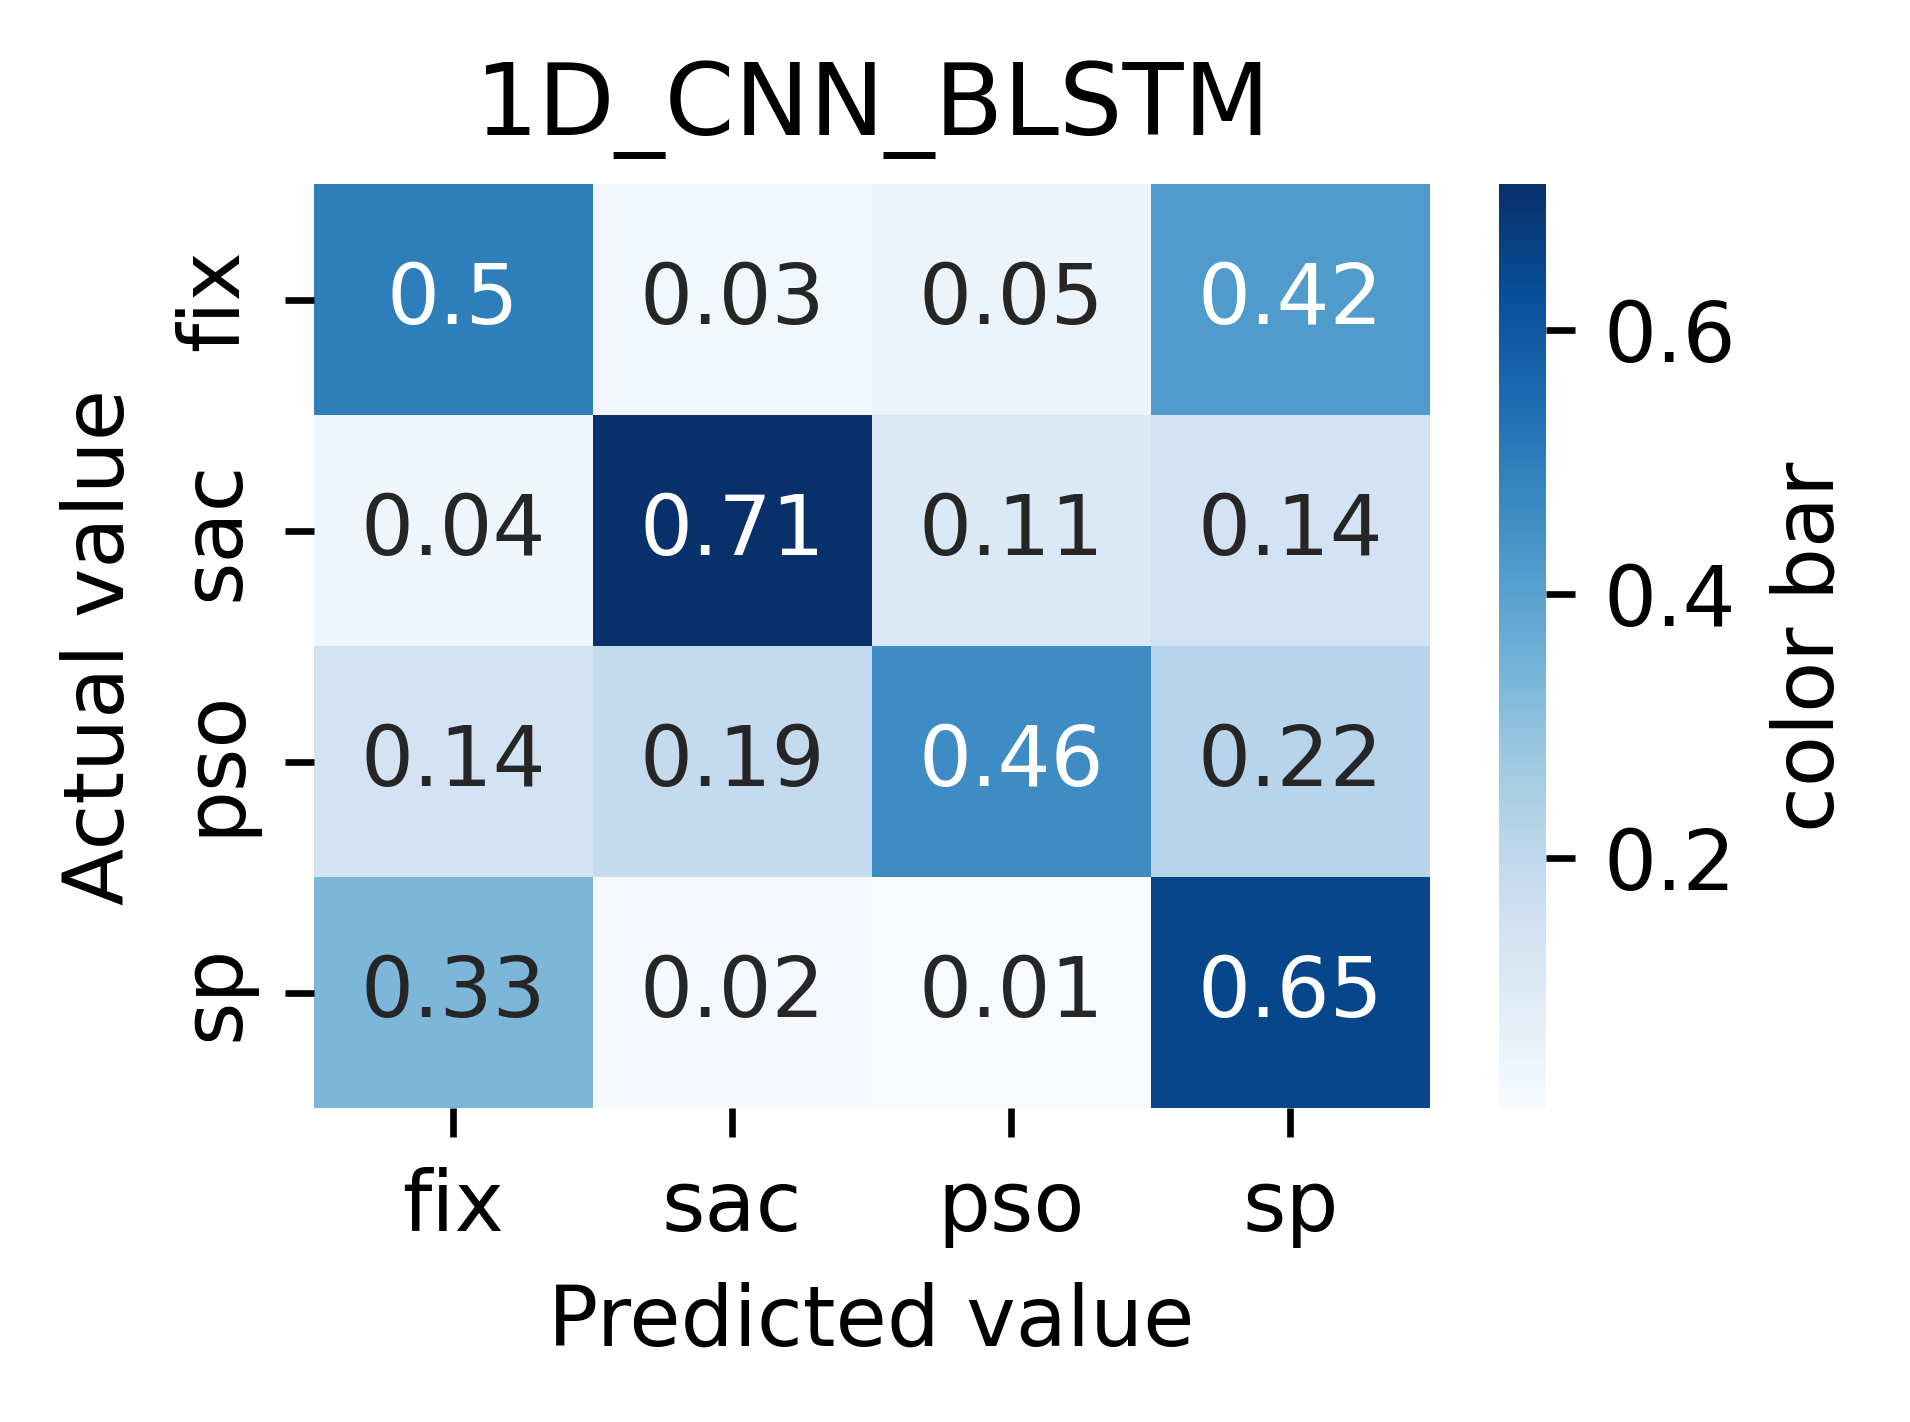

Fixation recall= 50.0
fixation_precision= 49.504950495049506
fixation_f1_score= 49.75124378109452
saccade_recall= 71.0
saccade_precision= 74.73684210526316
saccade_f1_score= 72.82051282051282
PSO recall= 45.54455445544554
PSO precission= 73.01587301587301
PSO_f1_score= 56.09756097560975
SP recall= 64.35643564356435
SP precission= 45.454545454545446
SP_f1_score= 53.27868852459015


In [ ]:
create_model(4, 50, train_data_shape=((X_a_train.shape)), dropout_rate=0.3,
                 padding_mode='valid',
                 num_conv_layers=3, conv_filter_counts=(32, 16, 8),
                 num_dense_layers=1, dense_units_count=(32,),
                 num_blstm_layers=1, blstm_unit_counts=(16,),
                 unroll_blstm=False,
                 stateful=False,
                 no_bidirectional=True)